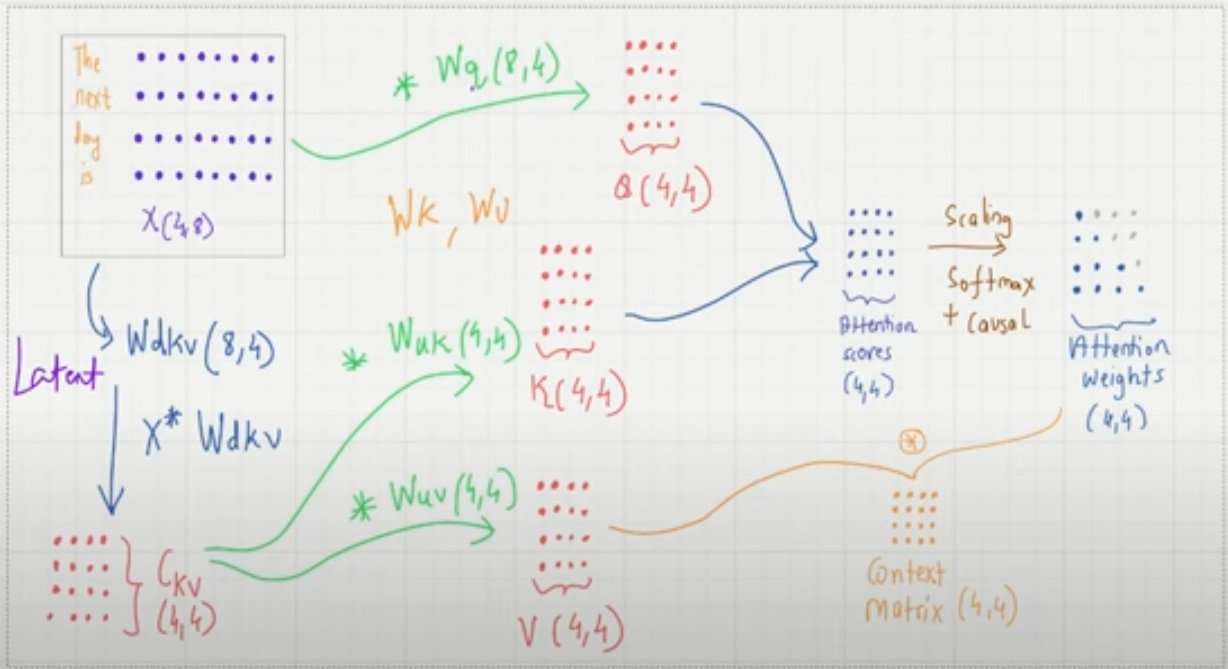

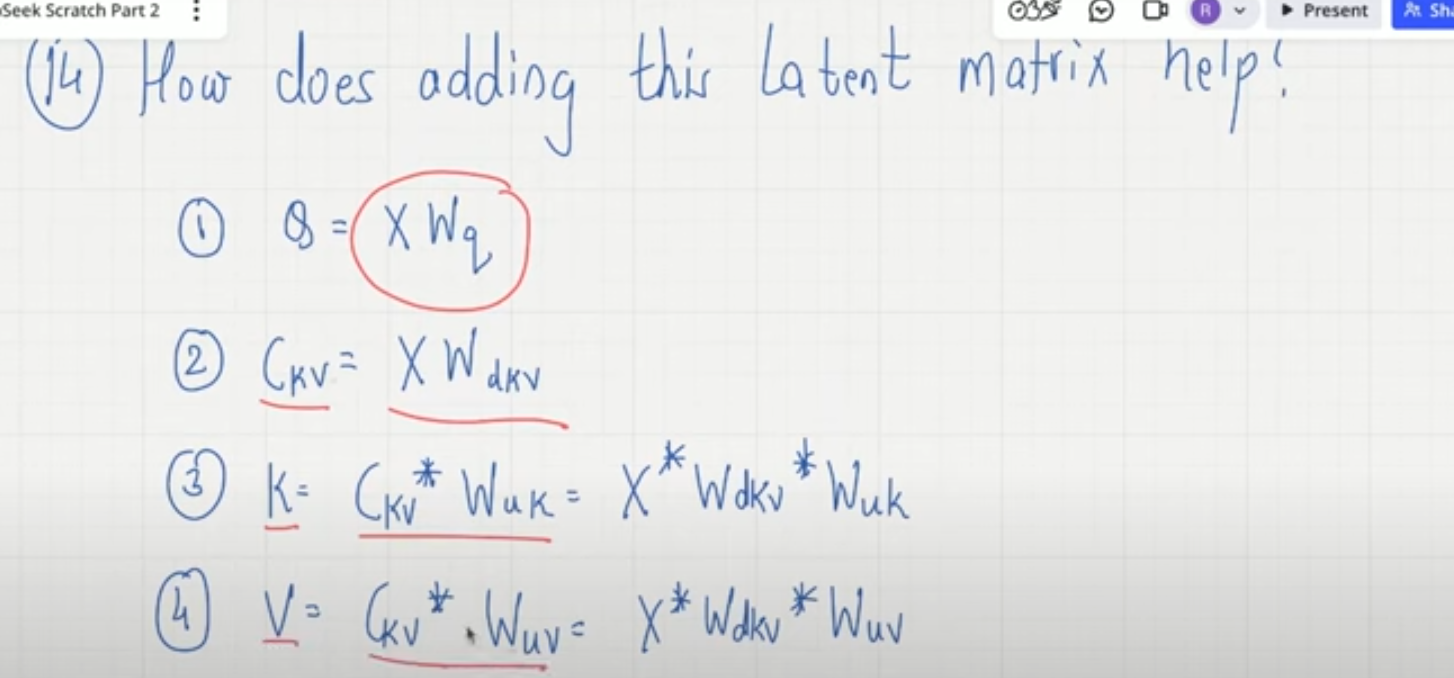

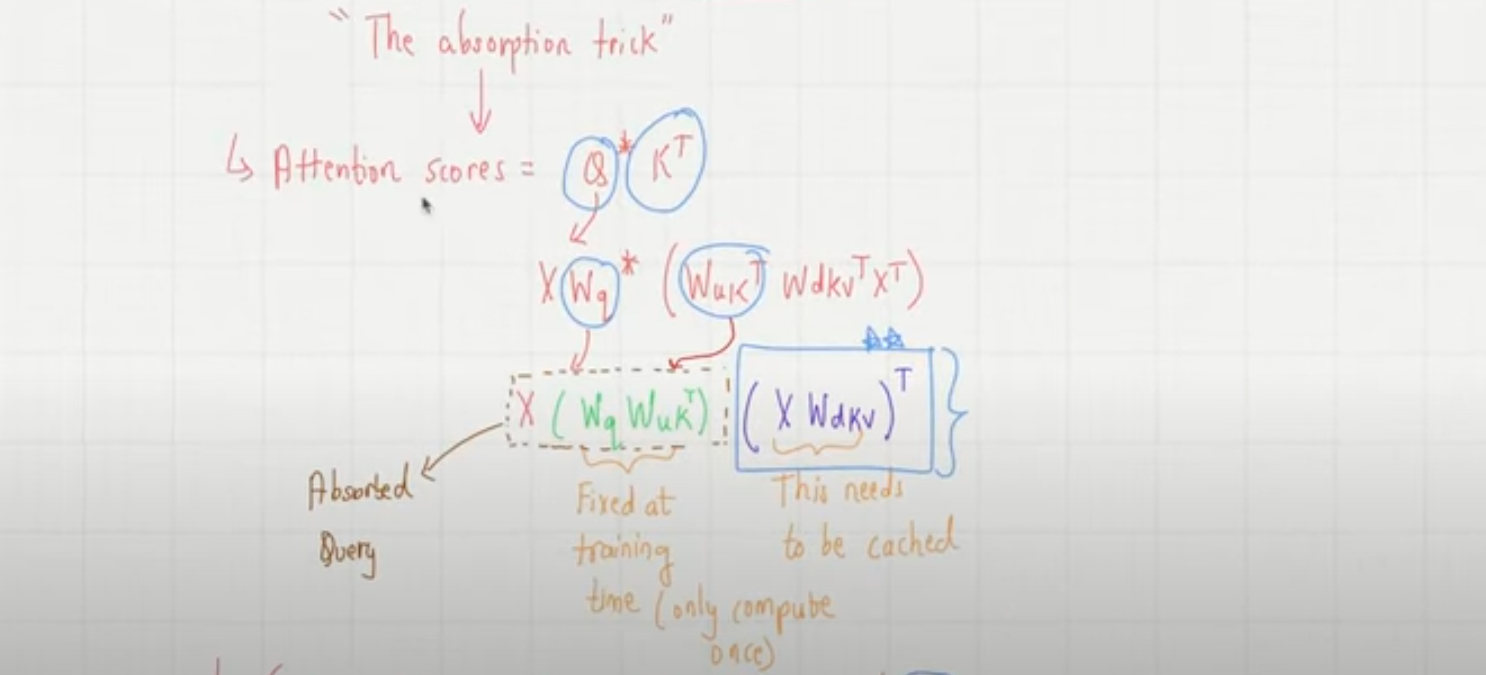

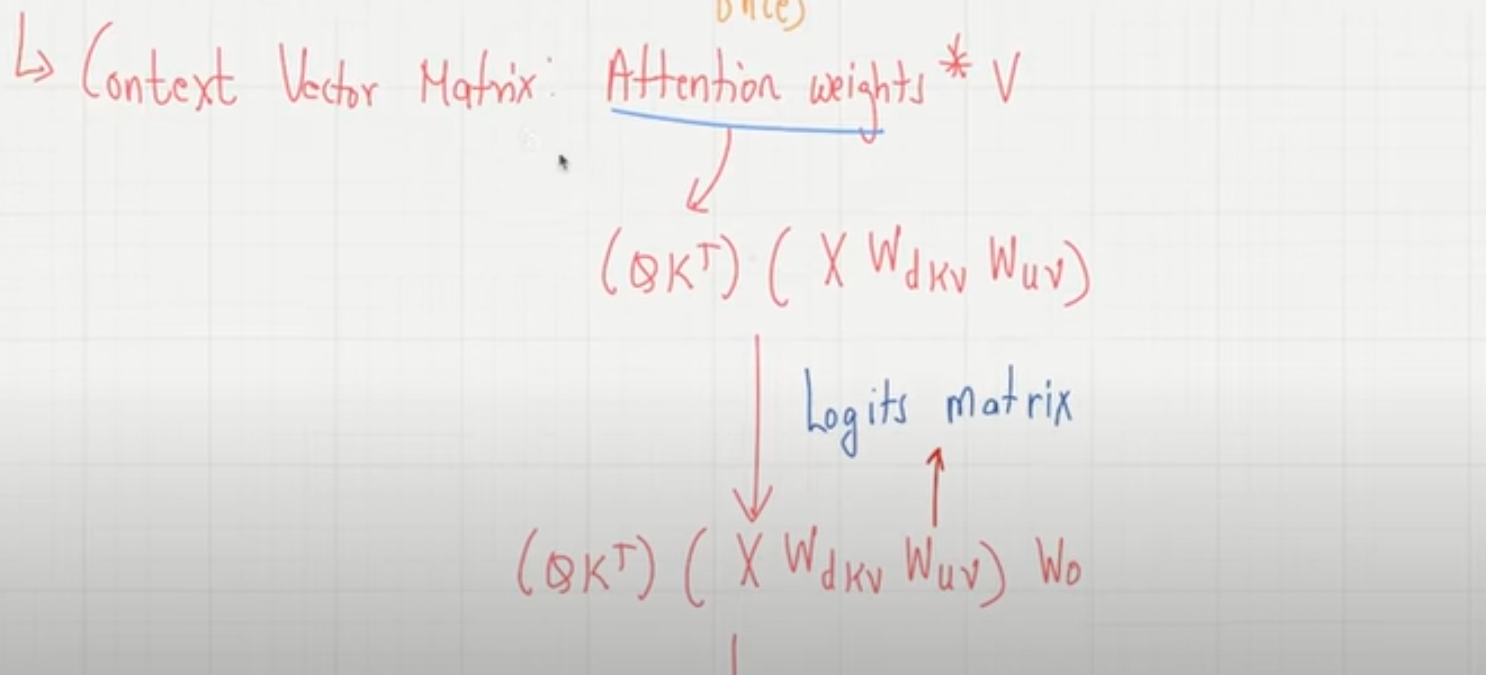

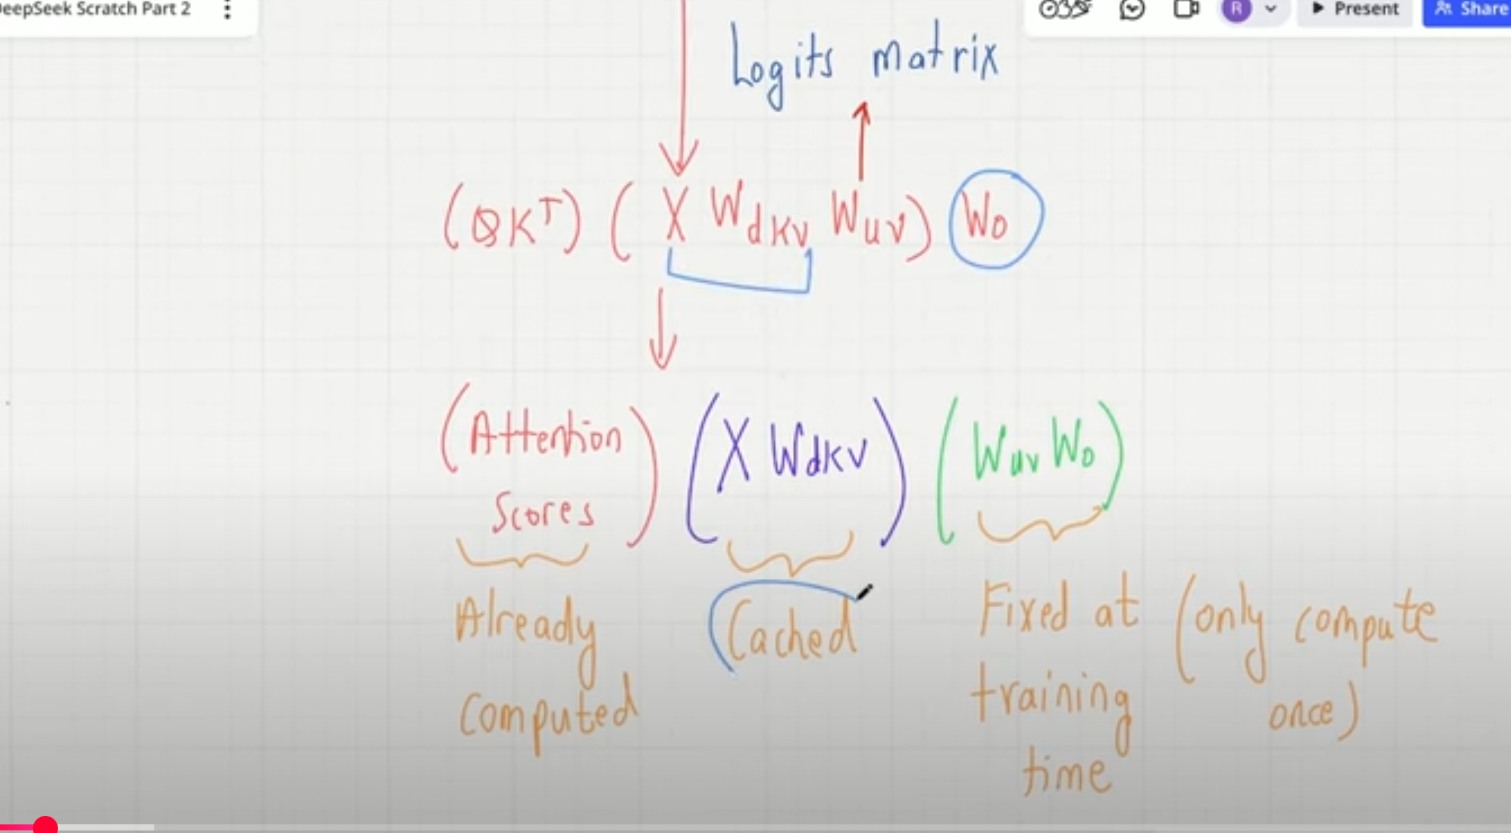

In [51]:
import torch
import torch.nn as nn
import torch.functional as F

In [3]:
d_model = 8
kv_latent_dim = 4
n_heads = 2
dh = d_model / n_heads # head dimension

In [ ]:
class RopelessMLA(nn.Module):
    def __init__(self, d_in, d_model, kv_latent_dim, n_heads):
        super().__init__()
        self.d_model = d_model
        self.kv_latent_dim = kv_latent_dim
        self.d_in = d_in
        self.num_heads = n_heads
        self.dh = d_model // n_heads

        self.w_q = nn.Linear(d_in, d_model, bias=False)
        self.w_dkv = nn.Linear(d_in, kv_latent_dim, bias=False)
        self.w_uk = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.w_uv = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)

        self.ln = nn.LayerNorm(kv_latent_dim)
        self.register_buffer('absorbed_k', None) # holds W_q @ w_uk

    def forward(self, x, kv_cache = None, past_length = 0):
        batch, num_token, d_in = x.size()

        # computing absorbed_k once : w_q @ w_uk
        if self.absorbed_k is None:
            absorbed = torch.matmul(self.w_q.weight, self.w_uk.weight) # (d_in, latent_dim)
            self.absorbed_k = absorbed.view(self.num_heads, self.dh, -1) #(n_heads, dh, ___)

        # compress x into latent KV Space
        new_c_kv = self.ln(self.w_dkv(x)) # batch, num_token, latent_dim
        if kv_cache is None:
            c_kv = new_c_kv
        else:
            c_kv = torch.cat([kv_cache, new_c_kv], dim=1) # batch, num_token+1, latent_dim

        token_full = c_kv.size(1)

        # decompose V to full and split it into heads
        v_full = self.w_uv(c_kv)
        v = v_full.view(batch, token_full, self.num_heads, self.dh).transpose(1,2)


        # use input x directly (since w_q is absorbed)

        q = x.view(batch, num_token, self.num_heads, self.dh)

        # compute attention score
        attn_score = torch.zeros(batch, self.num_heads, num_token, token_full)
        for h in range(self.num_heads):
            tmp = torch.matmul(q[:,:,h], self.absorbed_k[h])
            attn_score[:, h] = torch.bmm(tmp, c_kv.transpose(1,2))

        # scale and apply casual mask
        attn_score = attn_score / (self.dh**0.5)
        mask = torch.tril(torch.ones(num_token, token_full), diagonal=past_length)
        attn_score = attn_score.masked_fill(mask.view(1,1,num_token, token_full) == 0, float('-inf'))

        attn_weights = torch.softmax(attn_score, dim = -1)  # batch , n_heads, num_token, token_full

        # applying attention weight to each's V sepately
        out_heads = []
        for h in range(self.num_heads):
            context_h = torch.matmul(attn_score[:, h], v[:, h])
            out_heads.append(context_h)

        out = torch.cat(out_heads, dim = -1) # batch, num_token, d_model

        return self.w_o(out), c_kv

In [68]:
model = RopelessMLA(d_in = 512, d_model=512, n_heads=8, kv_latent_dim=256)
x = torch.randn(2, 5, 512)

out, cache = model(x)
print(out.shape)
print(cache.shape)

torch.Size([2, 5, 512])
torch.Size([2, 5, 256])
